<a href="https://colab.research.google.com/github/dpriyabijosh/Depression_detection/blob/main/Traditional_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

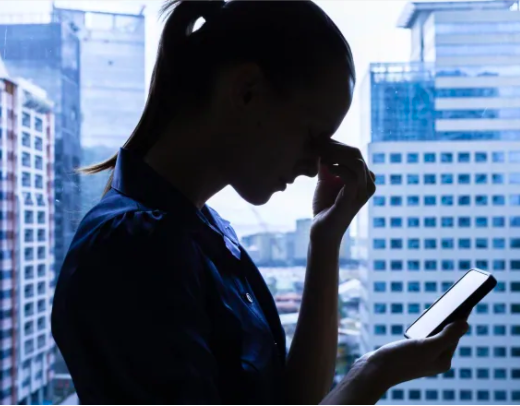

Depression is a mental illness that affects the quality of life which can lead to suicide. The major problem of the illness is that the chance of not knowing about the symptoms are very high. As per WHO, 280 million people world-wide suffer with this illness. The illness got worse due to the pandemic situation and a lot of people committed suicide which makes the importance to detect it in the early stages (Stephen & Prabu, 2019). It can be quite challenging for health care organisations to identify depression in the early stages because people are reluctant to seek care when necessary or uninformed of their mental state. In this era, people are very comfortable expressing their emotions in social media as posts, messages, and comments rather than speaking or sharing their emotions to other individuals (Burdisso et al., 2019). Social networking platforms represent a person’s personal life (Stephen & Prabu, 2019) which can be used for identifying the symptoms of mental illness such as depression by using natural language processing (NLP) with machine learning(ML) techniques. 

This implementation is to create a framework to detect early stage depression symptoms using different machine learning models.

## 1. Install and Load Essential Libraries

In [ ]:
!pip install import-ipynb
!pip install wordcloud
!pip install nltk
import os
import re
import nltk
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import drive
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
import gensim 
from gensim.models import Word2Vec 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import trange, tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import import_ipynb
import torch
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 29.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/My Drive/Colab Notebooks"
os.chdir(path)

Mounted at /content/drive


In [ ]:
# Import from pre-processing notebook
#from DepressionDetection_preprocessing import *
from DepressionDetection_preprocessing import *

## 2. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
import torch
# Calling checking GPU function from pre-processing notebook
set_Cuda()

There are 1 GPU(s) available.
Device name: Tesla T4


## 2. Dataset

##2.1 Train Dataset Preparation

In [ ]:
#Load dataset
data = initail_dataload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Transform and clean the dataset

#Rename the columns
data.rename(columns={'raw_tweet' :'tweet'},inplace=True)

# Perform Cleaning and Lemmatization
data['tweet'] = data['tweet'].apply(clean_tweet)

In [ ]:
 # Removing empty rows
data = clean_empty_rows(data,'tweet')

Initial size (10314, 2)
Shape after cleaning (10278, 2)


## 2.2 Test dataset Preparation

In [ ]:
# Load data and set labels
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/validation_data.csv', 
                        dtype= {'raw_tweet': str, 'label':int}, nrows=500,  usecols=[0,1])


In [ ]:
test_data.head()

,raw_tweet,label
0,@_TASOfficial_ I really miss XYZ since 2016 i ...,1
1,There's not much an 8 mile depression run can'...,1
2,How to Overcome Depression#WednesdayThoughts #...,0
3,Real Talk #Kanye has never pulled himself full...,0
4,@andrea_r so it would seem. Good if you wanted...,0


In [ ]:
#Rename the columns
test_data.rename(columns={'raw_tweet' :'tweet'},inplace=True)
# Perform Cleaning and Lemmatization
test_data['tweet'] = test_data['tweet'].apply(clean_tweet)

In [ ]:
 # Removing empty rows
test_data = clean_empty_rows(test_data,'tweet')

Initial size (500, 2)
Shape after cleaning (500, 2)


In [ ]:
test_data.head()

,tweet,label
0,tasofficial really miss xyz since post anime d...,1
1,there be not much mile depression run cannot f...,1
2,how overcome depression aprile,0
3,real talk never pull fully depression suffer m...,0
4,would seem good want multi user video site als...,0


## Apply TF-IDF 

In information retrieval, TF-IDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We will use TF-IDF to vectorize our text data before feeding them to machine learning algorithms. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Creating TF-IDF tensors for training and testing dataset

In [ ]:
def tfidf(data, ngrams = 1):

    df_temp = data.copy(deep = True)
    #df_temp = basic_preprocessing(df_temp)
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngrams))
    tfidf_vectorizer.fit(df_temp['tweet'])

    list_corpus = df_temp["tweet"].tolist()
    list_labels = df_temp["label"].tolist()

    X = tfidf_vectorizer.transform(list_corpus)
    
    return X, list_labels, tfidf_vectorizer


def test_tfidf(data, vectorizer, ngrams = 1):

    df_temp = data.copy(deep = True)
    #df_temp = basic_preprocessing(df_temp)

    # No need to create a new TfidfVectorizer here!

    list_corpus = df_temp["tweet"].tolist()
    list_labels = df_temp["label"].tolist()

    X = vectorizer.transform(list_corpus)
    
    return X, list_labels


In [ ]:
train_x, train_y, count_vectorizer  = tfidf(data, ngrams = 1)
test_x, test_y = test_tfidf(test_data, count_vectorizer, ngrams = 1)

In [ ]:
print(train_x,train_y)

  (0, 9121)	0.4670047622503953
  (0, 7395)	0.38844325618031916
  (0, 7248)	0.5724024284730207
  (0, 7184)	0.45792920317712077
  (0, 4571)	0.30606321817434756
  (1, 9115)	0.5012021240256012
  (1, 6807)	0.8653302438215285
  (2, 11267)	0.20076017766207313
  (2, 11133)	0.2152744091243172
  (2, 11131)	0.2988973122309574
  (2, 10928)	0.3196770892129238
  (2, 10759)	0.23749707554780444
  (2, 9841)	0.23558497894891578
  (2, 9195)	0.3099882363819152
  (2, 7903)	0.367974499420992
  (2, 7580)	0.18782427409851482
  (2, 3678)	0.2988973122309574
  (2, 3659)	0.19831931757362867
  (2, 3471)	0.28118109457925267
  (2, 80)	0.367974499420992
  (3, 7991)	0.27209373686115285
  (3, 7480)	0.6938043982625781
  (3, 6943)	0.23335079503690143
  (3, 6586)	0.46900467240511795
  (3, 2173)	0.28835989664406897
  :	:
  (10275, 12121)	0.3097779764373483
  (10275, 10675)	0.5436736309986799
  (10275, 7627)	0.31338440177937527
  (10275, 6763)	0.24900219195544065
  (10275, 6448)	0.23216922188278138
  (10275, 3915)	0.2697221

In [ ]:
print(test_x, test_y)

  (0, 12427)	0.38487842035660474
  (0, 10920)	0.38487842035660474
  (0, 10084)	0.25428280184107493
  (0, 9128)	0.18922642750464796
  (0, 8680)	0.2204568723788396
  (0, 8186)	0.38487842035660474
  (0, 7184)	0.22516363133135642
  (0, 6573)	0.3685285519266393
  (0, 4917)	0.17604297097969407
  (0, 3664)	0.22440278353044718
  (0, 2894)	0.10621112229327526
  (0, 453)	0.35692813566346804
  (1, 11089)	0.26494572532200095
  (1, 9574)	0.296720113025857
  (1, 7770)	0.1775135950065478
  (1, 7395)	0.23060020592421354
  (1, 7120)	0.397190507103838
  (1, 6949)	0.2798994506724702
  (1, 4034)	0.464681906407585
  (1, 3702)	0.38168666569072973
  (1, 2894)	0.12823370752561172
  (1, 2893)	0.2614528909960166
  (1, 1661)	0.2409696290212193
  (1, 981)	0.12840389160641036
  (2, 8142)	0.5441188836986313
  :	:
  (496, 5286)	0.26229577543884713
  (496, 4742)	0.27193801978151616
  (496, 4443)	0.3022776207557327
  (496, 2923)	0.3000020287582114
  (496, 2894)	0.11721589130805642
  (496, 1143)	0.34889221861111136
  (

##Function

In [ ]:
from sklearn.preprocessing import MinMaxScaler # Importing to do standardisation
from sklearn.model_selection import train_test_split #Importing to split our data for training
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score,confusion_matrix, classification_report,mean_squared_error
from collections import Counter 
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#Spliting train and test set for machine learning
def trainNtest(X,target):
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.80, stratify=target, random_state=40)# The dataset is divided into 70 and 30
    return X_train,X_test,y_train,y_test

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
from numpy.ma.core import mean
from statistics import mean, stdev
def cross_validation(model, x, y):
  # Create StratifiedKFold object.
   skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
   lst_accu_stratified = []
   
   for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x[train_index], x[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        mdl = model.fit(x_train_fold, y_train_fold)
        #prediction_model(mdl,x,y)
        lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
   print('List of possible accuracy:', lst_accu_stratified)
   print('\nMaximum Accuracy That can be obtained from this model is:',
          max(lst_accu_stratified)*100, '%')
   print('\nMinimum Accuracy:',
          min(lst_accu_stratified)*100, '%')
   print('\nOverall Accuracy:', mean(lst_accu_stratified)*100, '%')
   print('\nStandard Deviation is:', stdev(lst_accu_stratified)) 
   #prediction_model(model,x,y)     

In [ ]:
#Function to find the cross validation score
def crossValidationScore(model,x,y):
    scores = cross_val_score(model, x, y, cv=5)
    print("Accuracy cross validation :",round(scores.mean()*100,2),"%")
    prediction_model(model,x,y)

# Split Train and Test dataset

We will randomly split the entire training data into two sets: a train set with 90% of the data and a validation set with 10% of the data. We will perform hyperparameter tuning using cross-validation on the train set and use the validation set to compare models.

In [ ]:
# X = data.tweet.values
# y = data.label.values



# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = trainNtest(X, y)

In [ ]:
# Function to see the accuracy, classification report and confusion matrix
def prediction_model(model,X_test,y_test):
    y_pred = model.predict(X_test)
    c_matrix =confusion_matrix(y_test,y_pred)
    clr = classification_report(y_test,y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy", round(accuracy,2) )
    plt.figure(figsize=(8,8))
    sns.heatmap(c_matrix,annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
    plt.xlabel("Predicted Value")
    plt.ylabel("Actual Value")
    plt.title("Confusion matrix")
    plt.show()
    print(clr)

### Checking Distribution Training data set

In [ ]:
#Function to check class imbalance by plotting the target
import seaborn as sns
def checkingImbalance(target):    
    b=sns.countplot(x=target, 
                       facecolor=(0, 0, 0, 0),
                       linewidth=5,
                       edgecolor=sns.color_palette("dark", 3))
    plt.xlabel('Y-train',fontsize=15)
    plt.ylabel('Count',fontsize=15)
    plt.title('Y-train distribution plot')
    x_labels = ['Non-depressed','Depressed']
    b.set_xticklabels(x_labels,fontsize=12)

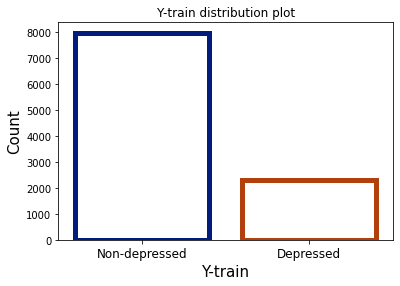

In [ ]:
#Function to check class imbalance by plotting the target
checkingImbalance(train_y)

### Training Test dataset

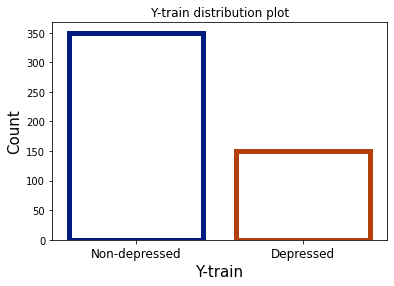

In [ ]:
checkingImbalance(test_data['label'])

# Sampling Techniques:


###SMOTE Oversampler to solve class imbalance issue

In [ ]:
#Function to create sample using SMOTE
def applySmote(X_train,y_train):
  sm = SMOTE(random_state=42)
  x, y = SMOTE().fit_resample(X_train, y_train) 
  return x, y

###RandomUnderSampler to solve class imbalance issue

In [ ]:
#Function to create sample using Random undersampler
def applyOverSampler(x,y):
    ros = RandomOverSampler(random_state=42)
    x, y = ros.fit_resample(x, y)
    return x, y

###ADASYS OverSampler 


In [ ]:
from imblearn.over_sampling import ADASYN 
def applyAdasynOS(X,y):
 #input DataFrame
 #X : Independent Variable 
 #y : Dependent Variable 
    sm = ADASYN()
    X, y = sm.fit_resample(X, y)
    return(X,y)

# Training Models

##Traditional models with TF-IDF

## SVM MODEL

In [ ]:
#svm_tf_idf = SVC()
svm_tf_idf = svm.SVC(C=5, kernel='rbf', degree=3, gamma=0.5)
svm_tf_idf = svm_tf_idf.fit(train_x, train_y)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs
Accuracy 0.8


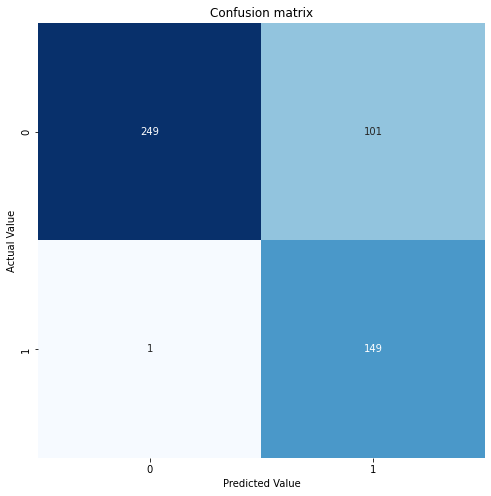

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       350
           1       0.60      0.99      0.74       150

    accuracy                           0.80       500
   macro avg       0.80      0.85      0.79       500
weighted avg       0.88      0.80      0.80       500



In [ ]:
%time
prediction_model(svm_tf_idf, test_x, test_y)

Apply SMOTE

In [ ]:
X_smote, y_smote  = applySmote(train_x, train_y)

In [ ]:
svm_tfidf_smote = svm_tf_idf.fit(X_smote, y_smote)

Accuracy 0.8


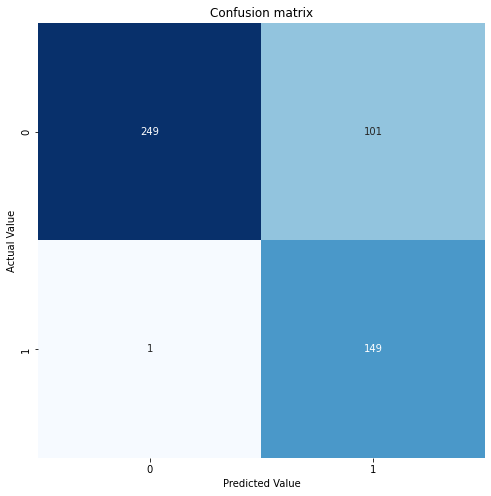

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       350
           1       0.60      0.99      0.74       150

    accuracy                           0.80       500
   macro avg       0.80      0.85      0.79       500
weighted avg       0.88      0.80      0.80       500



In [ ]:
prediction_model(svm_tfidf_smote, test_x, test_y)

##Apply RandomOverSampler

In [ ]:
X_ros, y_ros = applyOverSampler(train_x, train_y)

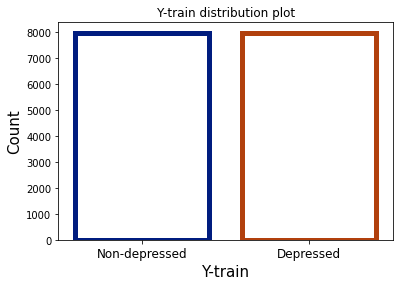

In [ ]:
checkingImbalance(y_ros)

In [ ]:
svm_tfidf_ros = svm_tf_idf.fit(X_ros, y_ros)

Accuracy 0.8


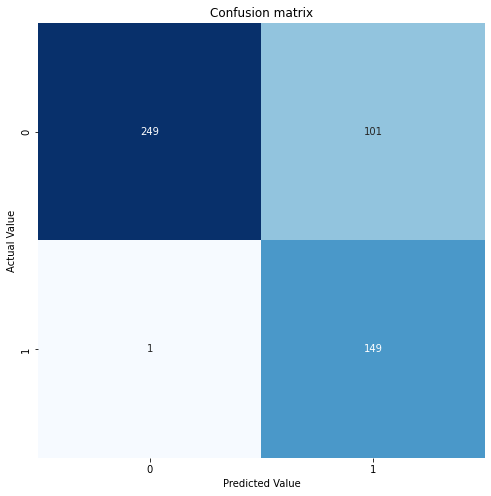

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       350
           1       0.60      0.99      0.74       150

    accuracy                           0.80       500
   macro avg       0.80      0.85      0.79       500
weighted avg       0.88      0.80      0.80       500



In [ ]:
prediction_model(svm_tfidf_ros, test_x, test_y)

##Apply ADASYN

In [ ]:
X_ada, y_ada = applyAdasynOS(train_x, train_y)

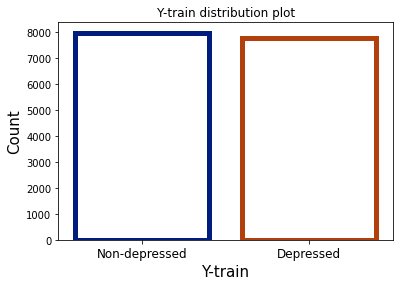

In [ ]:
checkingImbalance(y_ada)

In [ ]:
svm_tfidf_ada = svm_tf_idf.fit(X_ada, y_ada)

Accuracy 0.8


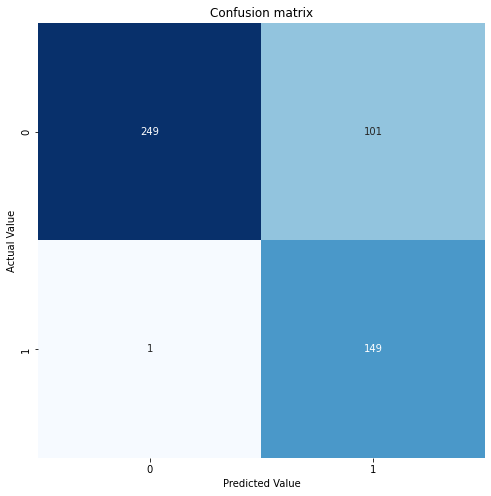

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       350
           1       0.60      0.99      0.74       150

    accuracy                           0.80       500
   macro avg       0.80      0.85      0.79       500
weighted avg       0.88      0.80      0.80       500



In [ ]:
prediction_model(svm_tfidf_ada, test_x, test_y)

## 2. Logistic Regression Classifier

In [ ]:
%time
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

logReg_tfIdf = LogisticRegression(random_state=0)
#LogisticRegression(penalty='l2', solver="sag", random_state=0, max_iter=2000)
logReg_tfIdf_model = logReg_tfIdf.fit(train_x, train_y)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 6.68 µs
Accuracy 0.79


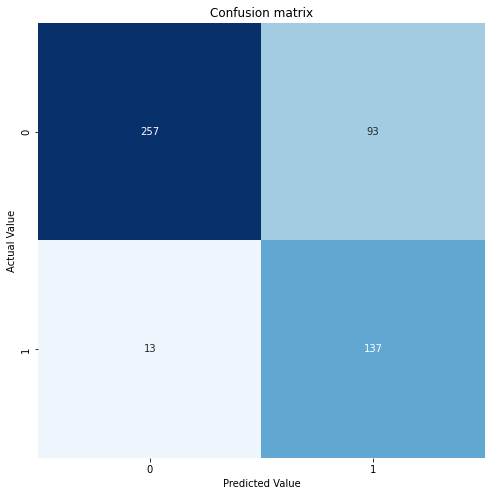

              precision    recall  f1-score   support

           0       0.95      0.73      0.83       350
           1       0.60      0.91      0.72       150

    accuracy                           0.79       500
   macro avg       0.77      0.82      0.78       500
weighted avg       0.84      0.79      0.80       500



In [ ]:
%time
prediction_model(logReg_tfIdf_model, test_x, test_y)

###Apply cross validation

###Apply SMOTE

In [ ]:
# The X_smote and Y_smote are already declared
logReg_tfIdf_smote = logReg_tfIdf.fit(X_smote, y_smote)

Accuracy 0.79


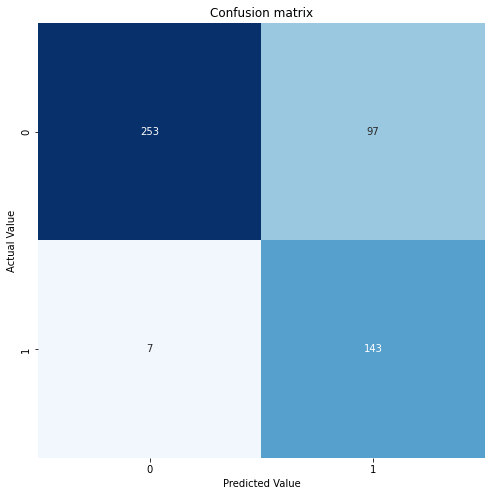

              precision    recall  f1-score   support

           0       0.97      0.72      0.83       350
           1       0.60      0.95      0.73       150

    accuracy                           0.79       500
   macro avg       0.78      0.84      0.78       500
weighted avg       0.86      0.79      0.80       500



In [ ]:
prediction_model(logReg_tfIdf_smote, test_x, test_y)

##Apply RandomOverSampler

In [ ]:
# Using already sampled X_ros and y_ros
logReg_tfidf_ros = logReg_tfIdf.fit(X_ros, y_ros)

Accuracy 0.79


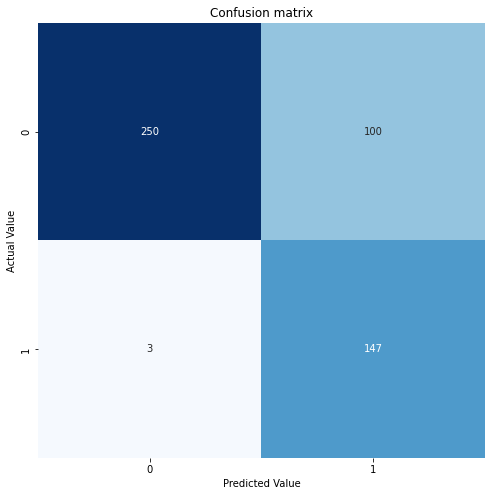

              precision    recall  f1-score   support

           0       0.99      0.71      0.83       350
           1       0.60      0.98      0.74       150

    accuracy                           0.79       500
   macro avg       0.79      0.85      0.78       500
weighted avg       0.87      0.79      0.80       500



In [ ]:
prediction_model(logReg_tfidf_ros, test_x, test_y)

##Apply ADASYN

In [ ]:
# Using already sampled X_ada and y_ada
logReg_tfidf_ada = logReg_tfIdf.fit(X_ada, y_ada)

Accuracy 0.79


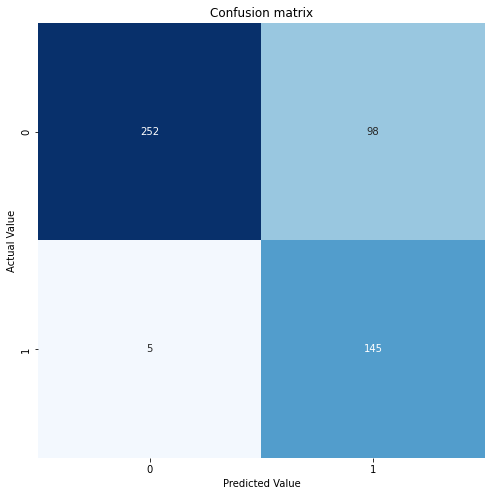

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       350
           1       0.60      0.97      0.74       150

    accuracy                           0.79       500
   macro avg       0.79      0.84      0.78       500
weighted avg       0.87      0.79      0.80       500



In [ ]:
prediction_model(logReg_tfidf_ada, test_x, test_y)

# Decision Tree Classifier

##Decision Tree with TF-IDF

In [ ]:
dT_tfIdf = DecisionTreeClassifier(random_state=0) 
dT_tfIdf_model = dT_tfIdf.fit(train_x, train_y)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
Accuracy 0.8


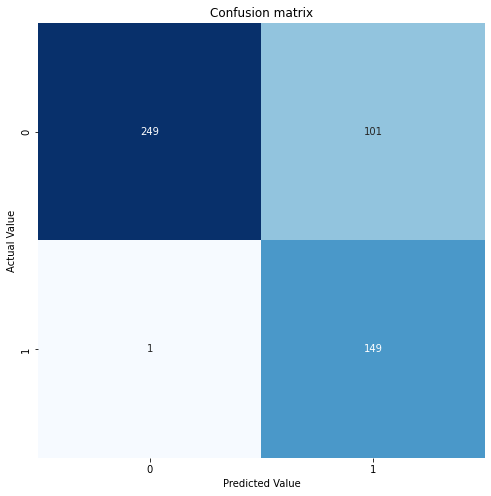

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       350
           1       0.60      0.99      0.74       150

    accuracy                           0.80       500
   macro avg       0.80      0.85      0.79       500
weighted avg       0.88      0.80      0.80       500



In [ ]:
%time
prediction_model(dT_tfIdf_model, test_x, test_y)

###Apply SMOTE

In [ ]:
# The X_smote and Y_smote are already declared
dT_tfIdf_smote = dT_tfIdf.fit(X_smote, y_smote)

Accuracy 0.8


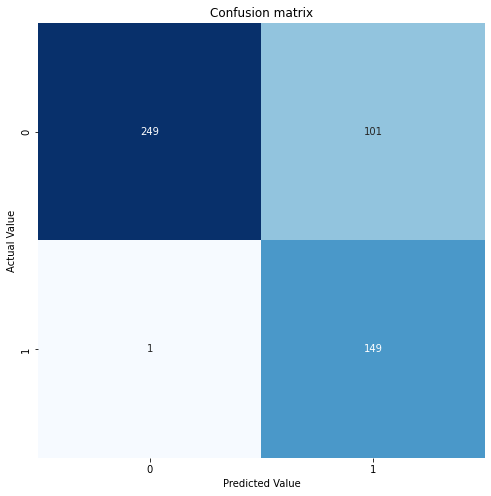

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       350
           1       0.60      0.99      0.74       150

    accuracy                           0.80       500
   macro avg       0.80      0.85      0.79       500
weighted avg       0.88      0.80      0.80       500



In [ ]:
prediction_model(dT_tfIdf_smote, test_x, test_y)

##Apply RandomOverSampler

In [ ]:
# Using already sampled X_ros and y_ros
dT_tfidf_ros = dT_tfIdf.fit(X_ros, y_ros)

Accuracy 0.8


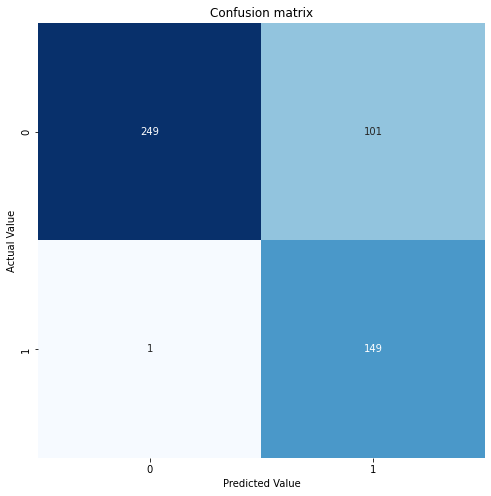

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       350
           1       0.60      0.99      0.74       150

    accuracy                           0.80       500
   macro avg       0.80      0.85      0.79       500
weighted avg       0.88      0.80      0.80       500



In [ ]:
prediction_model(dT_tfidf_ros, test_x, test_y)

##Apply ADASYN

In [ ]:
# Using already sampled X_ada and y_ada
dT_tfidf_ada = dT_tfIdf.fit(X_ada, y_ada)

Accuracy 0.8


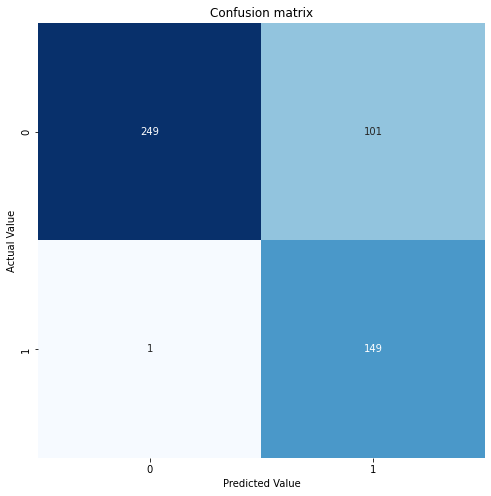

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       350
           1       0.60      0.99      0.74       150

    accuracy                           0.80       500
   macro avg       0.80      0.85      0.79       500
weighted avg       0.88      0.80      0.80       500



In [ ]:
prediction_model(dT_tfidf_ada, test_x, test_y)

# KNN Model

##KNN with TF-IDF

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
#dT_tfIdf = DecisionTreeClassifier(random_state=0) 
knn_tfIdf = knn.fit(train_x, train_y)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Accuracy 0.76


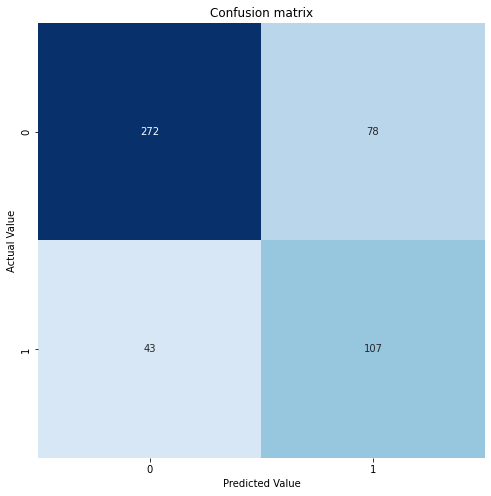

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       350
           1       0.58      0.71      0.64       150

    accuracy                           0.76       500
   macro avg       0.72      0.75      0.73       500
weighted avg       0.78      0.76      0.76       500



In [ ]:
%time
prediction_model(knn_tfIdf, test_x, test_y)

#### Cross validation

###Apply SMOTE

In [ ]:
# The X_smote and Y_smote are already declared
knn_tfIdf_smote = knn_tfIdf.fit(X_smote, y_smote)

Accuracy 0.57


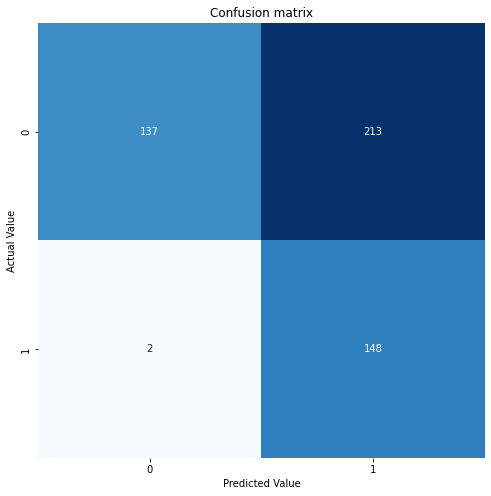

              precision    recall  f1-score   support

           0       0.99      0.39      0.56       350
           1       0.41      0.99      0.58       150

    accuracy                           0.57       500
   macro avg       0.70      0.69      0.57       500
weighted avg       0.81      0.57      0.57       500



In [ ]:
prediction_model(knn_tfIdf_smote, test_x, test_y)

##Apply RandomOverSampler

In [ ]:
# Using already sampled X_ros and y_ros
knn_tfidf_ros = knn_tfIdf.fit(X_ros, y_ros)

Accuracy 0.77


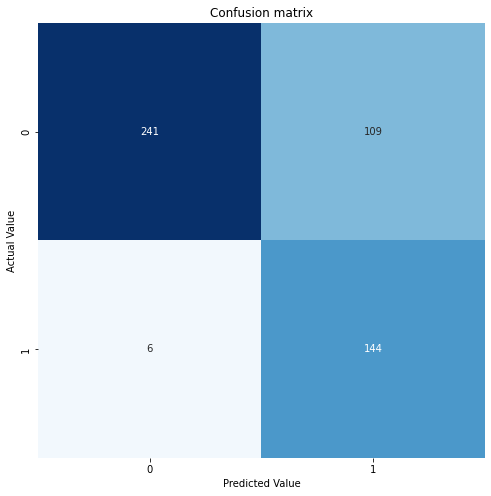

              precision    recall  f1-score   support

           0       0.98      0.69      0.81       350
           1       0.57      0.96      0.71       150

    accuracy                           0.77       500
   macro avg       0.77      0.82      0.76       500
weighted avg       0.85      0.77      0.78       500



In [ ]:
prediction_model(knn_tfidf_ros, test_x, test_y)

##Apply ADASYN

In [ ]:
# Using already sampled X_ada and y_ada
knn_tfidf_ada = knn_tfIdf.fit(X_ada, y_ada)

Accuracy 0.55


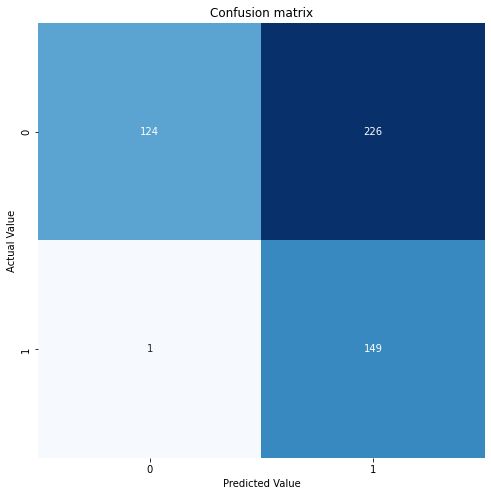

              precision    recall  f1-score   support

           0       0.99      0.35      0.52       350
           1       0.40      0.99      0.57       150

    accuracy                           0.55       500
   macro avg       0.69      0.67      0.54       500
weighted avg       0.81      0.55      0.54       500



In [ ]:
prediction_model(knn_tfidf_ada, test_x, test_y)

# Hyperparemeter Tuning & Evaluation

### 2.2. Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [ ]:
def model_predict(model,X_test):
  y_pred = model.predict(X_test)
  return y_pred